# Proyecto Final 

In [120]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz, DecisionTreeClassifier
import pandas as pd
from sklearn import svm
from math import sqrt, pi, exp 

sns.set(style="darkgrid")
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()



In [140]:
# Carga de datos
all_data = pd.read_csv('data_titanic_proyecto.csv')
# train_set, test_set = train_test_split(all_data, test_size=0.2)
# train_set, validation_set = train_test_split(train_set, test_size=0.2)
# 
# print("all_data shape", all_data.shape)
# print("train_set shape", train_set.shape)
# print("validation_set shape", validation_set.shape)



## Análisis exploratorio y limpieza de datos

Buscaremos valores faltantes en todo el dataset para saber si se espera tener que realizar imputación. 

In [119]:
all_data.isna().sum()

PassengerId             0
Name                    0
Age                   177
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 687
Embarked                2
passenger_class         0
passenger_sex           0
passenger_survived      0
dtype: int64

Vemos que Cabin tiene muchos valores faltantes, por lo que sería difícil realizar imputación, pero podemos utilizar estadística descriptiva para rellenar los valores faltantes en edad.

Veamos una muestra del data set para familiarizarnos con las variables

In [131]:
all_data.sample(4)

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
655,656,"Hickman, Mr. Leonard Mark",24.0,2,0,S.O.C. 14879,73.5000,NaN,S,Middle,M,N
552,553,"O'Brien, Mr. Timothy",NaN,0,0,330979,7.8292,NaN,Q,Lower,M,N
43,44,"Laroche, Miss. Simonne Marie Anne Andree",3.0,1,2,SC/Paris 2123,41.5792,NaN,C,Middle,F,Y
802,803,"Carter, Master. William Thornton II",11.0,1,2,113760,120.0000,B96 B98,S,Upper,M,Y


SibSp es la suma del número de hermanos y cónyugues a bordo para el pasajero. 

Parch es la cantidad de padres e hijos a bordo. 

Embarked es la inicial del puerto donde embarcaró el pasajero. 

Vemos que la clase del pasajero es categórica (Upper, Lower, Middle) pero nos interesa su correlación con otras variables, por lo que la cambiaremos a una categórica numérica. 

In [145]:
all_data.replace({"Upper" : 1, "Middle" : 2, "Lower" : 3}, inplace=True)

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
574,575,"Rush, Mr. Alfred George John",16.0,0,0,A/4. 20589,8.05,NaN,S,NaN,M,N


In [135]:
all_data.corr().abs().unstack()

PassengerId      PassengerId        1.000000
                 Age                0.036847
                 SibSp              0.057527
                 Parch              0.001652
                 Fare               0.012658
                 passenger_class    0.035144
Age              PassengerId        0.036847
                 Age                1.000000
                 SibSp              0.308247
                 Parch              0.189119
                 Fare               0.096067
                 passenger_class    0.369226
SibSp            PassengerId        0.057527
                 Age                0.308247
                 SibSp              1.000000
                 Parch              0.414838
                 Fare               0.159651
                 passenger_class    0.083081
Parch            PassengerId        0.001652
                 Age                0.189119
                 SibSp              0.414838
                 Parch              1.000000
          

### Clasificador Naive Bayes

In [25]:
class NaiveBayes:
    def __init__(self, train_x, train_y, x_labels=None):
        self.x_labels = x_labels
        df = self.__init_dataframe(train_x, train_y)
        by_class = df.groupby('y')
        self.means = by_class.mean()
        self.stdvs = by_class.std()
        self.cdist = by_class['y'].count() / df.shape[0]

    def __init_dataframe(self, train_x, train_y):
        df = pd.DataFrame()
        df['y'] = train_y
        for i,x in enumerate(train_x):
            label = self.x_labels[i] if self.x_labels else 'x_' + str(i)
            df[label] = x
        return df

    def predict(self, x_samples):
        probs = []
        for y in self.cdist.index:
            mean = self.means.iloc[y].to_numpy()
            std = self.stdvs.iloc[y].to_numpy()
            p_x = self.norm_pdf(x_samples, mean, std)
            probs.append(self.cdist[y] * np.prod(p_x, axis=1))
        probs = np.asarray(probs)
        return np.argmax(probs.T,axis=1)

    def norm_pdf(self, x, mean, std):
        e = np.exp(-((x - mean)**2 / (2 * std**2 )))
        return (1 / (sqrt(2*pi) * std)) * e


In [27]:
#train_x = df.drop('Y', axis=1).T.to_numpy()
#train_y = df[['Y']].T.to_numpy()[0]
##
##
#bayes = NaiveBayes(train_x, train_y)
#bayes.predict([[5,5],[0,5],[5,0],[1,0],[1,1],[1,2],[2,0],[2,1],[7,3]])

### Clasificador binario basado en regresión logísitca

In [93]:
  class BinaryLogisticRegression:
    def __init__(self, x, y):
        # Si x es unidimensional, convertir a columna. 
        # Si x es matriz, asumir una variable por columna.
        self.x = x.reshape(-1,1) if x.ndim == 1 else x 
        self.y = y.reshape(-1, 1)
        self.weights = None
        self.epochs = None 
        self.lr = None
        self.print_rate = None
        self.feed = None
        self.batch_size = None
        self.batch_iters = None
    
    def train(self, epochs, lr, batch_size, print_rate=10):
        self.print_rate = print_rate
        self.epochs = epochs
        self.lr = lr
        self.batch_size = min(batch_size, self.x.shape[0])
        self.batch_iters = int(self.x.shape[0]/self.batch_size)

        g = tf.Graph()
        with g.as_default():
            return self.__do_train()

    
    def __do_train(self):
        placeholder_x = tf.placeholder(tf.float64, [self.batch_size, self.x.shape[1]], "x")
        placeholder_y = tf.placeholder(tf.float64, [self.batch_size, self.y.shape[1]], "y")

        with tf.Session() as session:
            (weights_op, error_op) = self.__gradient_descent(placeholder_x, placeholder_y)
            self.before_training(session.graph, weights_op, error_op)
            session.run(tf.global_variables_initializer())    
            for epoch in range(1, self.epochs + 1):
                for i in range(self.batch_iters):
                    start_index  = i*self.batch_size
                    end_index = start_index + self.batch_size

                    x_batch = np.array(self.x[start_index:end_index])
                    y_batch = np.array(self.y[start_index:end_index])
                    self.feed = { placeholder_x: x_batch, placeholder_y: y_batch }


                    out = session.run([weights_op, error_op], self.feed)
                    self.error = out[1]
                    self.weights = out[0]
                    self.after_epoch(epoch, session)

    def __gradient_descent(self, x, y):
        n_samples = x.shape[0]
        n_independent_vars = x.shape[1] + 1

        bias_feature = tf.ones([n_samples, 1], tf.float64)
        x = tf.concat([x, bias_feature], axis=1)

        initial_weights = tf.zeros([n_independent_vars, 1], tf.float64)
        weights = tf.Variable(name="Weights", initial_value=initial_weights)
        logits = tf.matmul(x, weights)
        error = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=y))
        gradients = tf.gradients(error, weights)
        adjustment = tf.scalar_mul(-self.lr, gradients[0])
        weights = tf.assign(weights, (tf.add(weights, adjustment)))
        return (weights, error)

    def after_epoch(self, epoch, session):
        if epoch % self.print_rate == 0 or epoch == self.epochs:
            print("epoch:" + str(epoch) + " error: " + str(self.error))
    
    def before_training(self, graph, weights_op, error_op):
        # overridear para inicializar tensorboard, etc
        pass

    def predict(self, x):
        x = np.hstack((x,np.ones((x.shape[0],1))))
        logits = np.matmul(x, self.weights)
        logits_ph = tf.placeholder(tf.float32, logits.shape)
        with tf.Session() as session:
            feed = {logits_ph: logits}
            probs = session.run(tf.nn.sigmoid(logits_ph), feed_dict=feed)
            session.close()
        y = np.array(list(map(lambda p: 1 if p > 0.5 else 0, probs)))
        return y

In [105]:
weather=['Sunny','Sunny','Overcast','Rainy','Rainy','Rainy','Overcast','Sunny','Sunny',
'Rainy','Sunny','Overcast','Overcast','Rainy']
temp=['Hot','Hot','Hot','Mild','Cool','Cool','Cool','Mild','Cool','Mild','Mild','Mild','Hot','Mild']

play=['No','No','Yes','Yes','Yes','No','Yes','No','Yes','Yes','Yes','Yes','Yes','No']


df = pd.DataFrame({
    'weather' : weather,
    'temp' : temp,
     'play' : play
})


df.to_dict('index')
df["Y"] = df["play"].map( {'No': 0, 'Yes': 1}).astype(int)
df["weather_encoded"] = df["weather"].map( {'Overcast': 0, 'Rainy': 1,'Sunny':2}).astype(int)
df["temp_encoded"] = df["temp"].map( {'Cool': 0, 'Hot': 1,'Mild':2}).astype(int)


x_test = np.array([[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]])
y_test = [1,0,1]
x_test.reshape(-1,1)
print()



In [95]:

logreg = BinaryLogisticRegression(df[["weather_encoded","temp_encoded"]].to_numpy(), df["Y"].to_numpy())
logreg.train(2000, 0.6, 8, print_rate=500)

epoch:500 error: 0.19412925381893273
epoch:1000 error: 0.18436601554362148
epoch:1500 error: 0.1808835209881342
epoch:2000 error: 0.1790850880126646


In [96]:
logreg.predict(x_test)

array([1, 1, 1, 0, 1, 1, 0, 0, 0])

### Scikit Learn DecisionTreeClassifier 

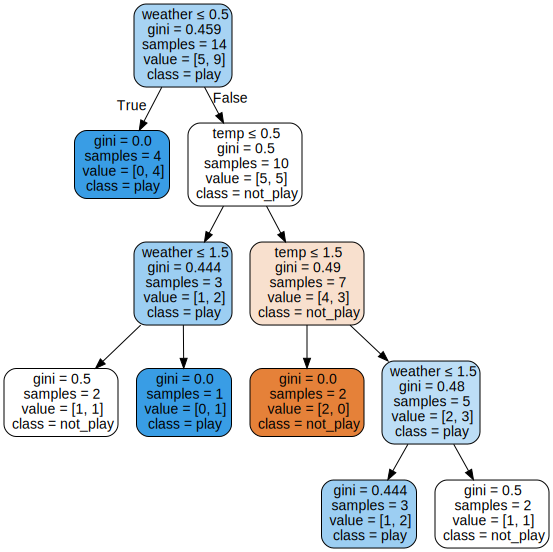

In [107]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(df[["weather_encoded","temp_encoded"]],df["Y"])
y_pred = decision_tree.predict(x_test)

gv_data = export_graphviz(decision_tree, out_file=None,
                                        feature_names=["weather","temp"],
                                        class_names=["not_play","play"],
                                        filled=True, rounded=True,
                                        special_characters=True)
graph = graphviz.Source(gv_data)
graph

def train_decision_tree(x, y):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(x, y)
    return decision_tree

### Support Vector Machine

In [111]:
svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(df[["weather_encoded","temp_encoded"]],df["Y"])
svm_classifier.predict(x_test)

def train_svm(x,y):
    svm_classifier = svm.SVC(kernel='linear')
    svm_classifier.fit(x,y)
    return svm_classifier

array([1, 1, 1, 1, 1, 1, 0, 0, 0])